In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import matplotlib
from tqdm.notebook import tqdm


import sys
# adding notebooks to the system path
sys.path.insert(0, '/home/southark/notebooks')


matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline

from perturbseq import *
import scanpy as sc

Aggreation of GEX and Guide UMI data and export of raw GEX matrix and guide UMI .h5

In [3]:
EXPERIMENT = '/scratch/sequencing/processed_overloading/202301_RPE1_E150_MAX_OL/'

In [4]:
#import 10x guide calls
guide_calls_10x = pd.read_csv(EXPERIMENT+'/outs/count/crispr_analysis/protospacer_calls_per_cell.csv')


In [5]:
from glob import glob
import os

#list of sample names
#gather from the workingfolder
COUNT_GLOB = '*outs*'

#perform for each project folder (i.e. if more sequencing was ordered)

unique_outs = sorted(set(map(lambda x: x.split('/')[-1],#.split('/outs')[0], 
                                glob(os.path.join(EXPERIMENT, COUNT_GLOB)))))


In [9]:
for i, path in enumerate(cellranger_output_paths):
    print(i)

0


In [ ]:
#FILENAME = '/outs/filtered_feature_bc_matrix.h5'
FILENAME = '/count/filtered_feature_bc_matrix.h5' #since working from an aggr

# List of paths to the cellranger output folders
cellranger_output_paths = [EXPERIMENT+d+FILENAME for d in unique_outs]

cellranger_output_paths

In [10]:
# Import the data from each folder and concatenate them into a single AnnData object
adata_list = []
for i, path in enumerate(cellranger_output_paths):
    print(i)
    adata = sc.read_10x_h5(path, gex_only=False)#import full matrix
    adata.var_names_make_unique()
    adata.obs['dataset'] = 'normal_from_maxexp'#unique_outs[i]
    #adata.obs['cell_barcode'] = adata.obs.index.str.split('-').str[0]
    #adata.obs = adata.obs.reset_index().set_index('cell_barcode').rename(columns = {'index': 'old_barcode'})
    adata_list.append(adata)

0


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [11]:
adata_list[0].obs

,dataset
AAACCCAAGCTGTCCG-1,normal_from_maxexp
AAACCCAAGGAGGTTC-1,normal_from_maxexp
AAACCCACACGAGAAC-1,normal_from_maxexp
AAACCCACAGTCTACA-1,normal_from_maxexp
AAACCCAGTGCTGATT-1,normal_from_maxexp
...,...
TTTGTTGCATGTGCTA-2,normal_from_maxexp
TTTGTTGGTGCGGATA-2,normal_from_maxexp
TTTGTTGGTTAGGGAC-2,normal_from_maxexp
TTTGTTGTCACCCTTG-2,normal_from_maxexp


In [12]:
adata_list[0].var.feature_types.value_counts()

Gene Expression         36601
CRISPR Guide Capture      156
Name: feature_types, dtype: int64

In [13]:
adata = adata_list[0]#.concatenate(adata_list[1:], join='outer') use if working from count

In [14]:
adata_guides = adata[:,adata.var['feature_types'].isin(['CRISPR Guide Capture'])]

#take gex only for gex output
adata_gex = adata[:,adata.var['feature_types'].isin(['Gene Expression'])]

In [15]:
adata_guides.var = adata_guides.var.rename(columns={'gene_ids': 'guide_identity'}).reset_index().set_index('guide_identity').rename(columns={'index': 'guide_target'})
adata_guides.var['guide_target'] = adata_guides.var.guide_target.map(lambda x: x.split('-')[0])
adata_guides.var

,guide_target,feature_types,genome
guide_identity,,,
127_ADAM10_P1P2_ENSG00000137845,ADAM10,CRISPR Guide Capture,
1893_CSE1L_P1P2_ENSG00000124207,CSE1L,CRISPR Guide Capture,
2124_DDX47_P1P2_ENSG00000213782,DDX47,CRISPR Guide Capture,
2238_DLD_P1P2_ENSG00000091140,DLD,CRISPR Guide Capture,
2527_EIF1AX_P1P2_ENSG00000173674,EIF1AX,CRISPR Guide Capture,
...,...,...,...
non-targeting_03760,NTC,CRISPR Guide Capture,
non-targeting_01195,NTC,CRISPR Guide Capture,
non-targeting_00236,NTC,CRISPR Guide Capture,


In [16]:
adata_guides.X

<26684x156 sparse matrix of type '<class 'numpy.float32'>'
	with 87477 stored elements in Compressed Sparse Row format>

In [17]:
chunk_size = 1000

# Create a generator object that yields chunks of the masked dataframe
chunks = (adata_guides[chunk] for chunk in adata_guides.chunked_X(chunk_size=chunk_size))

# Create an empty list to store the stacked chunks
stacked_list = []

# Iterate over the chunks mask and stack them
for chunk in adata_guides.chunked_X(chunk_size=chunk_size):
    df_chunk = adata_guides[chunk[1]:chunk[2],].to_df()
    print((chunk[1],chunk[2]))
    m = df_chunk > 0
    masked_chunk = df_chunk.mask(~m)
    stacked_chunk = masked_chunk.stack()
    stacked_list.append(stacked_chunk)        
        
guide_umis = pd.concat(stacked_list)

(0, 1000)
(1000, 2000)
(2000, 3000)
(3000, 4000)
(4000, 5000)
(5000, 6000)
(6000, 7000)
(7000, 8000)
(8000, 9000)
(9000, 10000)
(10000, 11000)
(11000, 12000)
(12000, 13000)
(13000, 14000)
(14000, 15000)
(15000, 16000)
(16000, 17000)
(17000, 18000)
(18000, 19000)
(19000, 20000)
(20000, 21000)
(21000, 22000)
(22000, 23000)
(23000, 24000)
(24000, 25000)
(25000, 26000)
(26000, 26684)


In [18]:
guide_umis[guide_umis >= 5]

                    guide_identity                   
AAACCCAAGGAGGTTC-1  9691_UXT_P1P2_ENSG00000126756       1382.0000
AAACCCACACGAGAAC-1  7538_RPS8_P1P2_ENSG00000142937       273.0000
AAACCCAGTGCTGATT-1  5900_NUP62_P1P2_ENSG00000213024     2669.0000
                    9621_URI1_P1P2_ENSG00000105176        65.0000
AAACCCAGTGGCTGCT-1  non-targeting_00236                  902.0000
                                                           ...   
TTTGTTGCATGTGCTA-2  6671_PPP1R37_P1P2_ENSG00000104866    261.0000
TTTGTTGGTGCGGATA-2  6556_POLR3B_P1P2_ENSG00000013503     796.0000
TTTGTTGGTTAGGGAC-2  5699_NKX6-1_P1P2_ENSG00000163623     509.0000
TTTGTTGTCACCCTTG-2  6558_POLR3D_P1P2_ENSG00000168495      65.0000
TTTGTTGTCTTGTTAC-2  4313_POGLUT3_P1P2_ENSG00000178202   1714.0000
Length: 35247, dtype: float32

In [19]:
guide_umis.tail(20)

                    guide_identity                   
TTTGTTGCATACGCAT-2  9621_URI1_P1P2_ENSG00000105176       109.0000
TTTGTTGCATCTGTTT-2  2238_DLD_P1P2_ENSG00000091140        996.0000
                    6679_PPP2CB_P1P2_ENSG00000104695       1.0000
                    7460_RPL32_P1P2_ENSG00000144713        1.0000
                    7507_RPS18_P1P2_ENSG00000231500        1.0000
                    7539_RPS9_P1P2_ENSG00000170889         1.0000
                    8680_TANGO6_P1P2_ENSG00000103047       1.0000
                    9909_XRCC6_P1P2_ENSG00000196419        1.0000
TTTGTTGCATGTGCTA-2  4953_MED30_P1P2_ENSG00000164758        1.0000
                    6671_PPP1R37_P1P2_ENSG00000104866    261.0000
TTTGTTGGTGCGGATA-2  6556_POLR3B_P1P2_ENSG00000013503     796.0000
                    7438_RPL14_P1P2_ENSG00000188846        3.0000
TTTGTTGGTTAGGGAC-2  2553_EIF3I_P1P2_ENSG00000084623        1.0000
                    5699_NKX6-1_P1P2_ENSG00000163623     509.0000
TTTGTTGTCACCCTTG-2  35

In [20]:
guide_umis.index.names = ['cell_barcode', 'guide_identity']

In [21]:
all_guides = guide_umis.reset_index().set_index('cell_barcode')

In [22]:
all_guides[0]

cell_barcode
AAACCCAAGGAGGTTC-1   1382.0000
AAACCCACACGAGAAC-1      2.0000
AAACCCACACGAGAAC-1      1.0000
AAACCCACACGAGAAC-1    273.0000
AAACCCACAGTCTACA-1      1.0000
                        ...   
TTTGTTGTCACCCTTG-2      1.0000
TTTGTTGTCACCCTTG-2      1.0000
TTTGTTGTCACCCTTG-2     65.0000
TTTGTTGTCACCCTTG-2      1.0000
TTTGTTGTCTTGTTAC-2   1714.0000
Name: 0, Length: 87477, dtype: float32

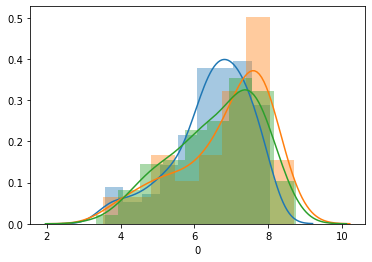

In [23]:
sns.distplot(np.log(all_guides[(all_guides.guide_identity == '7480_RPL8_P1P2_ENSG00000161016')&(all_guides[0] >= 25)][0]))
sns.distplot(np.log(all_guides[(all_guides.guide_identity == 'non-targeting_01377')&(all_guides[0] >= 25)][0]))
sns.distplot(np.log(all_guides[(all_guides.guide_identity == '7467_RPL37A_P1P2_ENSG00000197756')&(all_guides[0] >= 25)][0]))

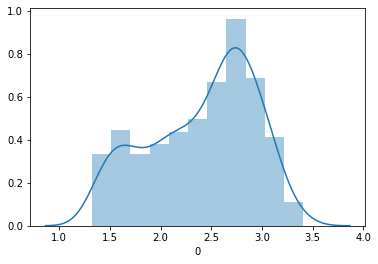

In [24]:
sns.distplot(np.log10(all_guides[(all_guides.guide_identity == '6671_PPP1R37_P1P2_ENSG00000104866')&(all_guides[0] >= 20)][0]+1))


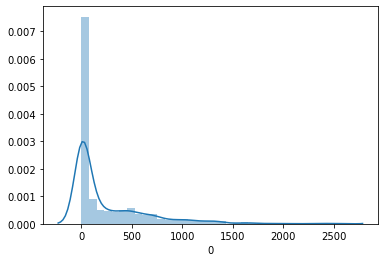

In [25]:
sns.distplot(all_guides[(all_guides.guide_identity == '6671_PPP1R37_P1P2_ENSG00000104866')&(all_guides[0] >= 1)][0])


# Export guide calls
for each sample import cell calls list

In [26]:
output_path = '/data/norman/southark/rpe1e150_standardized/'

date = '240227'

cells = 'rpe1_e150_maxol'

cas = 'crispri'

thres = 5

guide_umis.to_hdf(output_path+f'{date}_{cells}_{cas}_aggr_total_guide_umis.h5', key='guide_umis', mode='w')

#guide_umis[guide_umis >= thres].to_hdf(output_path+f'{date}_{cells}_{cas}_aggr_thres{thres}_guide_umis.h5', key='guide_umis', mode='w')

# Export GEX (raw)

In [27]:
#export raw gex aggr, no metadata formating

adata_raw = adata[:,adata.var['feature_types'].isin(['Gene Expression'])].copy()

adata_raw.write_h5ad(output_path+f'{date}_{cells}_{cas}_raw_scanpy_aggr.h5ad')

... storing 'dataset' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


# Create GEX matrix with some preliminary metadata

In [28]:
guide_calls_10x

,cell_barcode,num_features,feature_call,num_umis
0,AAAGTCCAGAAGGATG-1,1,127_ADAM10_P1P2_ENSG00000137845,3758
1,AAGTGAATCGGAAGGT-1,1,127_ADAM10_P1P2_ENSG00000137845,3422
2,AATCGTGGTCGAACAG-1,1,127_ADAM10_P1P2_ENSG00000137845,896
3,AATGAAGGTGGACAGT-1,1,127_ADAM10_P1P2_ENSG00000137845,3469
4,AATGAAGTCATCAGTG-1,1,127_ADAM10_P1P2_ENSG00000137845,3664
...,...,...,...,...
23139,GACTCTCGTACTGAGG-1,1,non-targeting_gfp,507
23140,TGTGAGTAGCTAGAAT-1,1,non-targeting_gfp,162
23141,TTTCACACAATACAGA-1,1,non-targeting_gfp,61
23142,GCCTGTTTCTATCGGA-2,1,non-targeting_gfp,255


In [29]:
guide_calls_10x['guide_identity'] = guide_calls_10x.feature_call.map(lambda x: x.split('|'))
guide_calls_10x['guide_umi_count'] = guide_calls_10x.num_umis.map(lambda x: x.split('|'))

cells_by_guide = guide_calls_10x.set_index(['cell_barcode','num_features','feature_call','num_umis']).apply(pd.Series.explode).reset_index()
cells_by_guide['guide_umi_count'] = cells_by_guide['guide_umi_count'].astype('int32')

In [30]:
cells_by_guide.groupby('guide_identity').guide_umi_count.min().sort_values()

guide_identity
6670_PPP1R37_P1P2_ENSG00000104866     6
815_BDP1_P1P2_ENSG00000145734        10
non-targeting_02622                  10
non-targeting_02969                  11
6559_POLR3E_P1P2_ENSG00000058600     11
                                     ..
5891_NUP205_P1P2_ENSG00000155561     49
non-targeting_03602                  54
4932_MED12_P1P2_ENSG00000184634      55
7449_RPL23A_P1P2_ENSG00000198242     61
non-targeting_gfp                    61
Name: guide_umi_count, Length: 156, dtype: int32

In [31]:
#number of cells called per droplet
UMI_cutoff= 5

#filter to catch any guide calls that were given too low of a threshold
filtered_calls = cells_by_guide[cells_by_guide.guide_umi_count >= UMI_cutoff]

num_cells = filtered_calls.groupby('cell_barcode').guide_identity.count().reset_index()


cell_identities = pd.merge(num_cells.rename(columns = {'guide_identity': 'number_of_cells'}), filtered_calls, on = 'cell_barcode')

cell_identities['good_coverage'] = True

cell_identities['gem_group'] = cell_identities.cell_barcode.str.split('-').str[1]

cell_identities.set_index('cell_barcode', inplace = True)

cell_identities.head()

,number_of_cells,num_features,feature_call,num_umis,guide_identity,guide_umi_count,good_coverage,gem_group
cell_barcode,,,,,,,,
AAACCCAAGAGGTCAC-2,1,1,5339_MTOR_P1P2_ENSG00000198793,1102,5339_MTOR_P1P2_ENSG00000198793,1102,True,2
AAACCCAAGGAGGTTC-1,1,1,9691_UXT_P1P2_ENSG00000126756,1382,9691_UXT_P1P2_ENSG00000126756,1382,True,1
AAACCCAAGGGATCAC-2,1,1,3570_GTF2E2_P1P2_ENSG00000197265,2208,3570_GTF2E2_P1P2_ENSG00000197265,2208,True,2
AAACCCACACGAGAAC-1,1,1,7538_RPS8_P1P2_ENSG00000142937,273,7538_RPS8_P1P2_ENSG00000142937,273,True,1
AAACCCACATGGCTAT-2,3,3,2795_EXOSC8_P1P2_ENSG00000120699|5339_MTOR_P1P...,186|294|722,2795_EXOSC8_P1P2_ENSG00000120699,186,True,2


In [32]:
import six

name_replacer = {'C3orf72': 'FOXL2NB',
                 'C19orf26': 'CBARP',
                 'KIAA1804': 'RP5-862P8.2',
                 'RHOXF2': 'RHOXF2B',
                }

cell_identities['guide_target'] = cell_identities['guide_identity'].map(lambda x: x.split('__')[0] if isinstance(x, six.string_types) else 'no_id')
cell_identities['guide_target'] = cell_identities['guide_target'].map(lambda x: x.split('_')[0])
cell_identities['guide_target'] = cell_identities['guide_target'].map(lambda x: name_replacer.get(x, x))
cell_identities['perturbed'] = cell_identities['guide_target'].map(lambda x: 'control' if 'negative' in x else x)

In [34]:
full = cell_identities[(cell_identities['number_of_cells'] > 0)]

full_top_UMI = full.sort_values('guide_umi_count', ascending = False).groupby(level = 0).first()

In [40]:
adata_gex.var = adata_gex.var.rename(columns={'gene_ids': 'gene_id'}).reset_index().set_index('gene_id').rename(columns={'index': 'gene_name'})

adata_gex.obs['UMI_count'] = adata_gex.X.sum(axis=1)

adata_gex.obs = pd.merge(adata_gex.obs, full_top_UMI, left_index=True, right_index=True, how='left')

In [41]:
#remove droplets without a guide assignment
adata_gex = adata_gex[~adata_gex.obs['feature_call'].isnull()].copy()

In [42]:
adata_gex.var['mean'] = pd.Series(adata_gex.X.mean(axis=0).A.flatten(), index=adata_gex.var.index)

#adata_gex = adata_gex[:, adata_gex.var['mean'] >= 0.05].copy() do not do this!!! (this was the culprit)
#adata_gex.var['in_matrix'] = True

# EXPORT GEX with guide assignments

here thresdholded features is formated like the feature calls from 10x, but is created from the actual guide calls using raw UMI counts

In [43]:
#write out scanpy file with metdadata
adata_gex.write_h5ad(output_path+f'{date}_{cells}_{cas}_scanpy_from_cellranger_aggr_singlets_and_multiplets_{thres}umi_cellranger_guide_calls.h5ad')

... storing 'dataset' as categorical
... storing 'feature_call' as categorical
... storing 'num_umis' as categorical
... storing 'guide_identity' as categorical
... storing 'gem_group' as categorical
... storing 'guide_target' as categorical
... storing 'perturbed' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


In [46]:
#create design matrix for single and multicells
full_design_matrix = full['guide_identity'].groupby(level = 0).apply(lambda x: '|'.join(x.astype(str))).str.get_dummies(sep='|')

In [47]:
#save design matrix to csv
full_design_matrix.to_csv(output_path+f'{date}_{cells}_{cas}_full_design_matrix_guide_identity.csv')